# Efficient coupling from SMF to HCF with a GIF lens

Cameron McGarry 2024

This notebook investigates the efficiency of SMF-GIF-HCF splices (single mode fibre, graded index fibre and hollow core fibre). The idea is to use the short GIF intermediarry section to expand the mode profile from the SMF to a size that will couple efficiently into the HCF fundamental.

This implements the numerical methods in **TODO -- point to Arxiv/ paper** and is intended to supplement that work rather than to replace it. Further details can be found therein. Please cite that work if you have used these methods for your research.

## SMF mode


First we calculate the mode of the single mode optical fibrre (SMF). This follows the usual methodology as can be found in various textbooks such as Optical Waveguide Theory by Snyder and Love (henceforth referred to as 'S&L').

The fibre parameter 

$V_\text{SMF} = k\rho(n_\text{co}^2 - n_\text{cl}^2)$

where $k$ is the wavenumber, $\rho_S$ is the core radius, $n_\text{cl}$ ($n_\text{co}$) is the cladding (core) refractive index and \text{NA} is the numerical aperture. We take the wavelength to be 780 nm.

In [3]:
import numpy as np

_wl = 780e-9
_k = 2*np.pi/_wl
rho_smf = 4.4E-6/2
n_co_smf = 1.4598
n_cl_smf =  1.4537
NA_smf = 0.13 # nominal - from datasheet
V_smf = _k*rho_smf*np.sqrt(n_co_smf**2 - n_cl_smf**2)
print(f'780HP V param: {V_smf:.3f}')

780HP V param: 2.363


The core and cladding parameters ($\tilde{U}$ and $\tilde{W}$) of the fibre can be found numerically by solving the eigenvalue equation (S&L equation 14-15)

$\tilde{U}\frac{J_1(\tilde{U})}{J_0(\tilde{U})} - \tilde{W}\frac{K_1(\tilde{W})}{K_0(\tilde{W})} = 0$

where we have introduce the (modified) Bessel function ($K_n$) $J_n$. Solutions are given in S&L table 14-4, but are easily reproduced

In [2]:
from scipy.special import jv, kn
import numpy as np

x0 = 1.8 # Starting point for fsolve

def eigenvalue_eqn(W, U):
    return U*(jv(1, U)/jv(0, U)) - W*(kn(1, W)/kn(0, W))

def eigenvalue_eqn_U(U, V):
    W = np.sqrt(V**2 - U**2)
    return eigenvalue_eqn(W, U)

from scipy.optimize import fsolve

Vs = np.arange(3, 2, -0.05)

Us = [fsolve(eigenvalue_eqn_U, x0, (V))[0] for V in Vs]

print('V       U        W')
for V in Vs:
    U = fsolve(eigenvalue_eqn_U, x0, (V))[0]
    W = np.sqrt(V**2 - U**2)
    print(f'{V:.2f} -- {U:.3f} -- {W:.3f}')

V       U        W
3.00 -- 1.771 -- 2.421
2.95 -- 1.762 -- 2.366
2.90 -- 1.753 -- 2.310
2.85 -- 1.744 -- 2.254
2.80 -- 1.734 -- 2.198
2.75 -- 1.724 -- 2.142
2.70 -- 1.714 -- 2.086
2.65 -- 1.703 -- 2.030
2.60 -- 1.693 -- 1.974
2.55 -- 1.681 -- 1.917
2.50 -- 1.670 -- 1.861
2.45 -- 1.658 -- 1.804
2.40 -- 1.645 -- 1.747
2.35 -- 1.632 -- 1.690
2.30 -- 1.619 -- 1.634
2.25 -- 1.605 -- 1.576
2.20 -- 1.591 -- 1.519
2.15 -- 1.576 -- 1.462
2.10 -- 1.561 -- 1.405
2.05 -- 1.545 -- 1.348


In particular for our fibre

In [3]:
U_smf = fsolve(eigenvalue_eqn_U, x0, (V_smf))[0]
W_smf = np.sqrt(V_smf**2 - U_smf**2)
print(f'780HP U param: {U_smf:.3f}')
print(f'780HP W param: {W_smf:.3f}')

780HP U param: 1.636
780HP W param: 1.705


The mode can now be plotted. Set the maximum value to 1 for now -- we'll normalise properly later.

<IPython.core.display.Javascript object>


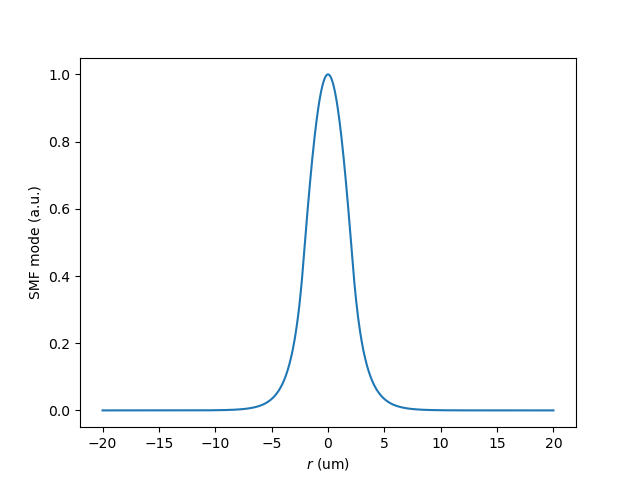

In [4]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

def smf_mode(rs):
    """
    Returns the SMF mode for 780HP. Units set so that maxium value is 1
    
    Takes
    rs: array of radial positions (in m)
    """
    mode = [jv(0, r*U_smf/rho_smf) / jv(0, U_smf) if np.abs(r) < rho_smf else kn(0, np.abs(r)*W_smf/rho_smf) / kn(0, W_smf) for r in rs]
    mode /= max(mode)
    return np.array(mode)

rs = np.linspace(-20E-6, 20E-6, 1000)
mode = smf_mode(rs)

fig, ax = plt.subplots(1, 1, num='SMF mode')
ax.plot(1E6*rs, mode)

ax.set_xlabel('$r$ (um)')
ax.set_ylabel('SMF mode (a.u.)'); 

## GIF mode

Light is directed into the GIF at a fusion splice. The mode in the GIF will have the form

$ \psi_\text{G}(R) = \sum_{l,m} a_{l,m}g_{l,m}(R)$

where we have

$g_{l,m}(R) = R^l \mathcal{L}_{m-1}(V_\text{G} R^2)\exp\left(-\frac{V_\text{G}R^2}{2}\right)$.

Note that in the S&L notation, $g_{l,m}$ is $F_l$. The fibre parameter of the GIF is 

$V_\text{G} = k\rho_\text{G}n_0\sqrt{2\Delta}$

where $\rho_\text{G}$ is the GIF core radius and $\Delta$ is the profile height parameter. This latter quantity determines the slope of the fibre index, which we write in terms of the radial position

$n^2(r) = n_0^2\left(1 - 2\Delta^2 \left(\frac{r}{\rho_\text{G}}\right)^2\right)$

so that $n_0$ is the maximum refractive index across the profile. We will also use the paramter $g = \sqrt{2}\Delta/\rho_\text{g}$ for convenience.

For [GIF625](https://www.thorlabs.com/thorproduct.cfm?partnumber=GIF625) $g$ can be found from the numerical aperture ($\text{NA}$) by $g=\text{NA}/{\rho_\text{G}n_0}$.

In [5]:
NA= 0.275
r = 60E-6/2
n0 = 1.45
g = NA/(r*n0)

rho_GIF = 30E-6

Delta = rho_GIF**2*g**2/2 # Using nomenclature of S&L
V_GIF = _k*rho_GIF*n0*np.sqrt(2*Delta)

from scipy.special import genlaguerre as Lag

def GIF_mode_lm(l, m, r):
    return (r/rho_GIF)**l * Lag(m-1, l)(V_GIF*(r/rho_GIF)**2)*np.exp(-0.5*V_GIF*(r/rho_GIF)**2)

It is also possible to quantify this in terms of the quarter pitch distance ($\text{QPD} = \pi/(2g)$), and to determine the maximum spot size that is achieved.

In [6]:
qpd = np.pi/(2*g)
print(f'Quarter-pitch distance: {1E6*qpd:.3f}um')

Quarter-pitch distance: 248.471um


The mode in the GIF is determined by finding the values $a_{l,m}$ from the overlap integral with the SMF mode.

$ a_{l,m} \propto \int g_{l,m}(R) \psi_\text{S}(R) \, R \mathrm{d}R.$

First, just plot some GIF modes as examples

So now we have the modes we can think about taking the overlap integrals.

We only consider $l=0$ here, $l>0$ is very weakly populated.

<IPython.core.display.Javascript object>


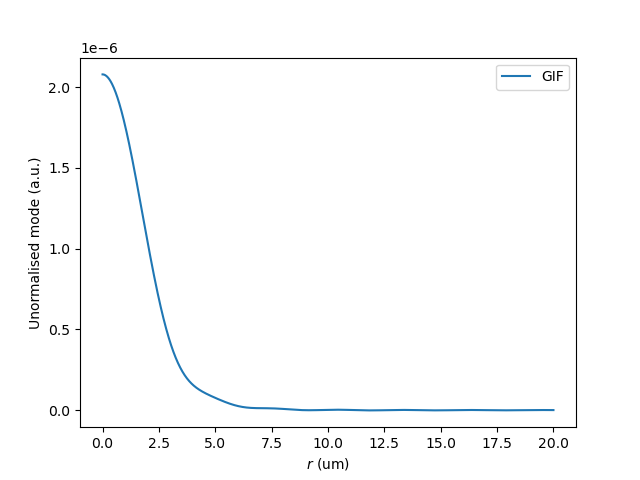

In [7]:
rs = np.linspace(0, 20E-6, 1000)

# Save coefficients in a list of tuples (l, m, a_lm)
alms = []
ls = [l for l in range(1)] # NOTE only allowing l=0 here
ms = [m for m in range(1,20)]
gif_mode = np.zeros(len(rs))

for l in ls:
    ams = []
    for m in ms:
        a_lm = np.trapz(3E5*GIF_mode_lm(l, m, rs)*smf_mode(rs)*rs, rs)
        gif_mode += a_lm*GIF_mode_lm(l, m, rs)
        alms.append((l, m, a_lm))
        ams.append(a_lm)
        
fig, ax = plt.subplots(1, 1, num='Mode in GIF')
ax.plot(1E6*rs, gif_mode, label='GIF')
ax.legend()

ax.set_xlabel('$r$ (um)')
ax.set_ylabel('Unormalised mode (a.u.)'); 

This gives us the shape, but not the amplitude of the resulting field. [We can calculate the efficency](https://www.rp-photonics.com/mode_matching.html) and use this to normalise the field

$\eta = \frac{\left|\int E_1 E_2 r \,\mathrm{d}r\right|^2}{\int |E_1|^2 r\,\mathrm{d}r \int |E_2|^2 r\,\mathrm{d}r}$.

Because of this efficiency we don't need to worry about the relative mode heights, just their shapes.

In [8]:
def calc_efficiency(mode_1, mode_2, rs):
    return np.abs(np.trapz(np.conjugate(mode_1)*mode_2*rs,rs))**2/(np.trapz(rs*np.abs(mode_1)**2, rs)*np.trapz(rs*np.abs(mode_2)**2, rs))

efficiency = calc_efficiency(gif_mode, smf_mode(rs), rs)
print(f'SMF-GIF handover efficiency: {100*efficiency:.2f}%')

SMF-GIF handover efficiency: 99.95%


Find normalisation for both modes. Ignore the integral over the angular part, we'll assume that we have angular symmetry.

In [9]:
smf_norm = np.sqrt(1/np.trapz(rs*np.abs(smf_mode(rs))**2, rs))
gif_norm = np.sqrt(1/np.trapz(rs*np.abs(gif_mode)**2, rs))

Now we can plot and compare the two modes.

<IPython.core.display.Javascript object>


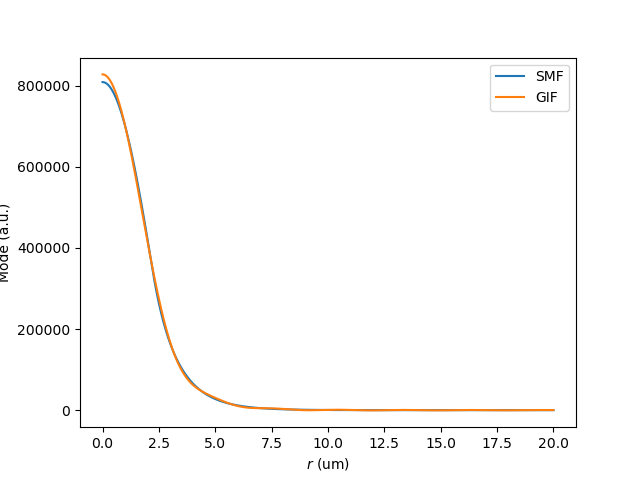

In [10]:
fig, ax = plt.subplots(1, 1, num='Modes in SMF and GIF')
ax.plot(1E6*rs, smf_norm*smf_mode(rs), label='SMF')
ax.plot(1E6*rs, gif_norm*gif_mode, label='GIF')
ax.legend()

ax.set_xlabel('$r$ (um)')
ax.set_ylabel('Mode (a.u.)'); 

These match nicely.

It's informative to look at the distibution across the modes.

<IPython.core.display.Javascript object>


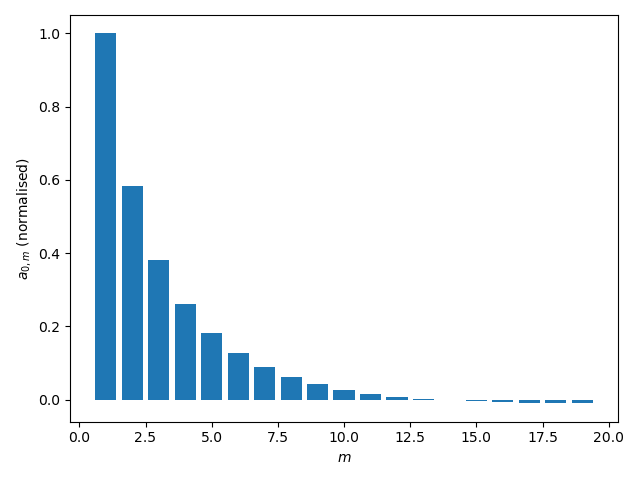

In [11]:
fig, ax = plt.subplots(1, 1, num='GIF mode amplitudes')

ams = [a for l, m, a in alms]
ams = np.array(ams) / ams[0] # normalise relative to each other

ax.bar(ms, ams)

ax.set_xlabel('$m$')
ax.set_ylabel('$a_{0,m}$ (normalised)'); 

## Propagation along the GIF

As the mode propagates along the GIF, each mode evolves independently, so that after a distance $L$ the mode is

$ \psi_\text{G}(R, L) = \sum_{l,m} a_{l,m}g_{l,m}(R)\exp{i\beta_{l,m}L}$

where we have introduced the propagation constant
$
\beta_{l,m} = \frac{V_\text{G}}{\rho_\text{G}} \sqrt{2\Delta}\left[1-\frac{2\rho_\text{G}^2g^2}{V_\text{G}}(2m + l -1)\right]^{1/2}.
$



In [12]:
def GIF_prop_const(l, m):
    return (V_GIF/(rho_GIF*np.sqrt(2*Delta)))*np.sqrt(1-4*Delta*(2*m+l-1)/V_GIF)

So we can now propagate over some length $L$ of GIF. So each mode evolves by some factor of $e^{j\beta L}$. We can check for varying lengths of GIF

<IPython.core.display.Javascript object>


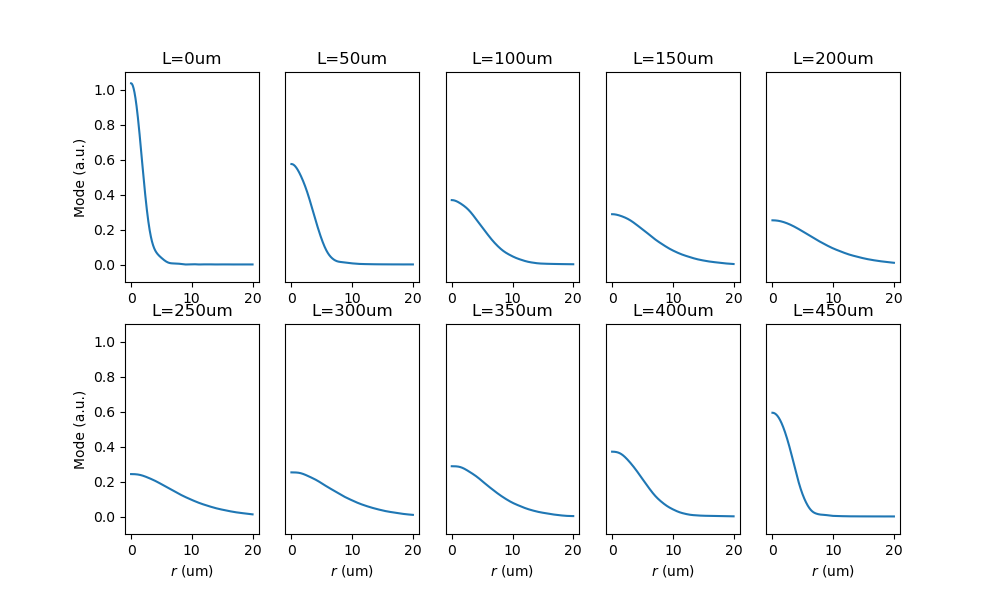

In [13]:
gif_lengths = [50E-6*i for i in range(10)]

scale = 1/8e5

plt.figure(num='Propagated mode in GIF', figsize=(10,6))

for i, gif_length in enumerate(gif_lengths):
    propagated_gif_mode = np.zeros(len(rs), dtype='complex128')
    for l, m, a_lm in alms:
        beta = GIF_prop_const(l, m)
        propagated_gif_mode += scale*gif_norm*a_lm*GIF_mode_lm(l, m, rs)*np.exp(1j*beta*gif_length)
        
    ax = plt.subplot(2,5,i+1)
    ax.grid(False)
    ax.title.set_text(f'L={gif_length*1E6:.0f}um')
    ax.plot(1E6*rs, np.abs(propagated_gif_mode))
    ax.set_ylim(-0.1, 1.1)
    
    if i > 4:
        ax.set_xlabel('$r$ (um)')
    if i == 0 or i==5:
        ax.set_ylabel('Mode (a.u.)')
    else:
        ax.set_yticks([])
        
fig.tight_layout()

It will be useful to be able to create this mode with a simple function

In [14]:
alms_initial_find = alms.copy()

def gif_mode_proped(rs, gif_length):
    propagated_gif_mode = np.zeros(len(rs), dtype='complex128')
    for l, m, a_lm in alms_initial_find:
        beta = GIF_prop_const(l, m)
        propagated_gif_mode += gif_norm*a_lm*GIF_mode_lm(l, m, rs)*np.exp(1j*beta*gif_length)
    return propagated_gif_mode

## Transmission to HCF - Bessel function mode

For a first approximation of transmission into HCF we will model the mode of the HCF as a something like a Bessel function. For a core radius $\rho_\text{H}$ we will assume the mode is proportional to a Bessel function of zeroth kind $J_0(r/\rho_\text{H})$ so that the first zero is at the edge of the core. Then we set the mode to zero for $r>\rho_\text{H}$.

Initially consider an arbitrary HCF with core diameter 24 um.

We can also compare to the GIF mode, which I'll arbitrarily scale to around the right height.

<IPython.core.display.Javascript object>


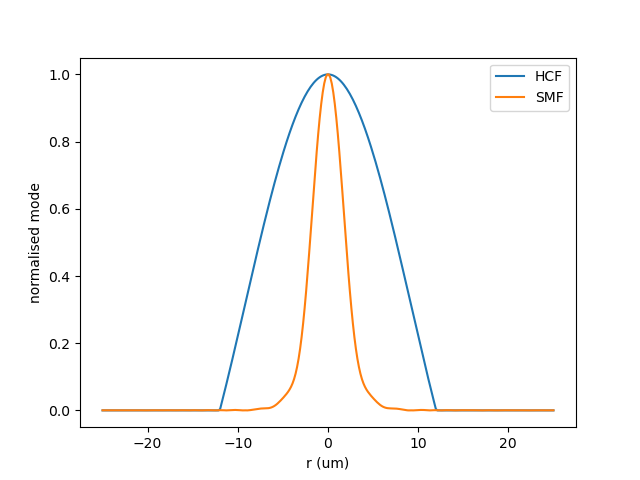

In [15]:
rho_hcf = 12E-6 # half core diameter
j00 = 2.40482555769577 # Bessel function first zero

def hcf_mode_bessel(r, radius=rho_hcf):
    return np.array([jv(0, r*j00/radius) if np.abs(r) < radius else 0 for r in rs])
    
rs = np.linspace(-25E-6, 25E-6, 300)
mode = hcf_mode_bessel(rs)
gif_mode_1 = np.abs(gif_mode_proped(rs, 0E-6))
gif_mode_1 = gif_mode_1 / max(gif_mode_1)

fig, ax = plt.subplots(1, 1, num='SMF and HCF mode profile')
ax.plot(1E6 * rs, mode, label='HCF')
ax.plot(1E6*rs, gif_mode_1, label='SMF')
ax.set_xlabel('r (um)')
ax.set_ylabel('normalised mode')

ax.legend();

And now look at the overlap for about one QPD of GIF

<IPython.core.display.Javascript object>


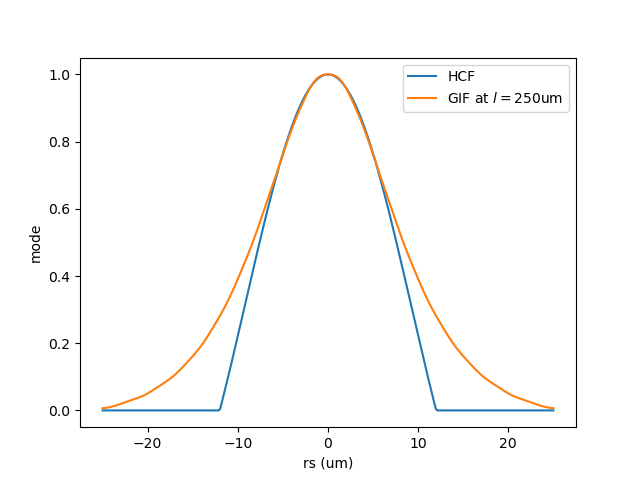

In [16]:
rs = np.linspace(-25E-6, 25E-6, 300)
mode = hcf_mode_bessel(rs)
gif_mode_1 = np.abs(gif_mode_proped(rs, 250E-6))
gif_mode_1 = gif_mode_1 / max(gif_mode_1)

fig, ax = plt.subplots(1, 1, num='HCF mode profile')
ax.plot(1E6 * rs, mode, label='HCF')
ax.plot(1E6*rs, gif_mode_1, label='GIF at $l=250$um')
ax.set_xlabel('rs (um)')
ax.set_ylabel('mode')

ax.legend();

Much improved. We can then calculate the efficiency as a function of $L$.

<IPython.core.display.Javascript object>


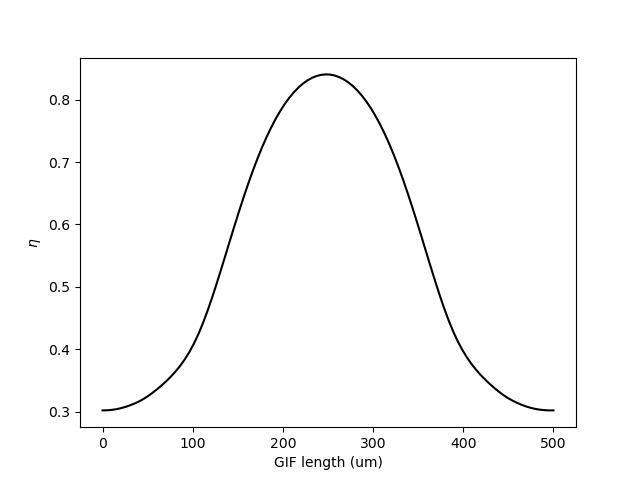

In [17]:
gif_lengths = np.linspace(0, 500E-6, 100)
efficiencies = []

rs = np.linspace(0, 25E-6, 300)
mode = hcf_mode_bessel(rs)

for gif_length in gif_lengths:
    gif_mode_l = gif_mode_proped(rs, gif_length)
    efficiencies.append(calc_efficiency(gif_mode_l, mode, rs))

fig, ax = plt.subplots(1, 1, num='GIF-HCF efficiency 1')
ax.plot(1E6 * gif_lengths, efficiencies, c='k')
ax.set_xlabel('GIF length (um)')
ax.set_ylabel('$\\eta$');

It's also instructive to look at the modes at various $L$

<IPython.core.display.Javascript object>


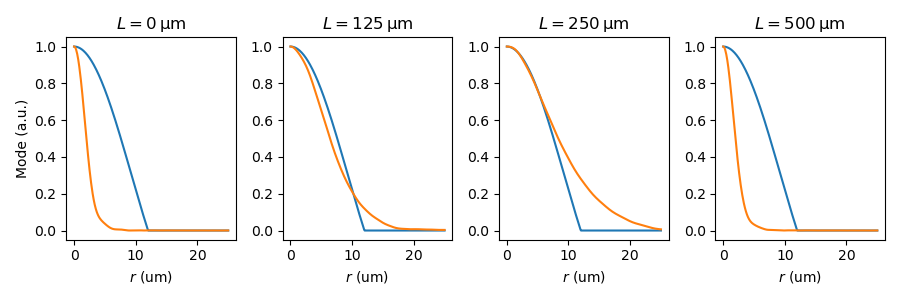

In [18]:
gif_lengths = [0, 125e-6, 250e-6, 500e-6]
rs = np.linspace(0E-6, 25E-6, 300)
mode = hcf_mode_bessel(rs)

fig = plt.figure(num='HCF-GIF mode comparison for report', figsize=(9,3))

for i, gif_length in enumerate(gif_lengths):
    gif_mode_l = np.abs(gif_mode_proped(rs, gif_length))
    gif_mode_l = np.abs(gif_mode_l / max(gif_mode_l))
    
    ax = plt.subplot(1,4,i+1)
    ax.grid(False)
    ax.title.set_text(f'$L=${gif_length*1E6:.0f}'+'$\,\mathrm{\mu m}$')
    ax.plot(1E6*rs, mode)
    ax.plot(1E6*rs, gif_mode_l)
    ax.set_ylim(-0.05, 1.05)
    

    ax.set_xlabel('$r$ (um)')
    if i == 0 or i==5:
        ax.set_ylabel('Mode (a.u.)')
        
fig.tight_layout()

## Vary HCF core diamter

Finally consider optimisation by varying the core diameter of the SMF. Begin with fixed $L$.

<IPython.core.display.Javascript object>


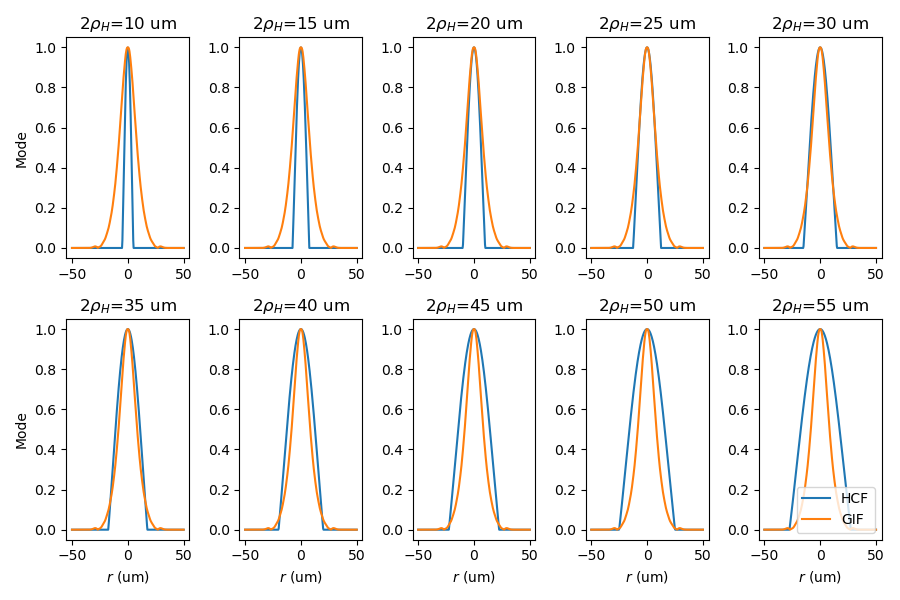

In [19]:
hcf_diameters = [10E-6+5E-6*i for i in range(10)]
#hcf_diameters = [25e-6, 30e-6, 35.4e-6]
rs = np.linspace(-50E-6, 50E-6, 300)
qp = np.pi*0.5/g
L =250e-6

# Create mode
gif_mode_l = np.abs(gif_mode_proped(rs, L))
gif_mode_l = gif_mode_l/max(gif_mode_l)

fig = plt.figure(num='Varying HCF mode (modes)', figsize=(9,6))

for i, hcf_diameter in enumerate(hcf_diameters):
    
    
    mode = hcf_mode_bessel(rs, radius=hcf_diameter/2)
    
    ax = plt.subplot(2,5,i+1)
    #ax = plt.subplot(1,3,i+1)
    ax.grid(False)
    ax.title.set_text('$2\\rho_H$'+f'={hcf_diameter*1E6:.0f} um')
    ax.plot(1E6*rs, mode, label='HCF')
    ax.plot(1E6*rs, gif_mode_l, label='GIF')
    ax.set_ylim(-0.05, 1.05)
    
    if i > 4:
        ax.set_xlabel('$r$ (um)')
    if i == 0 or i==5:
        ax.set_ylabel('Mode')
    if i == 9:
        ax.legend(loc='lower right')

fig.tight_layout()

And now use this to calculate efficiencies as a function of both core diameter and GIF length. Spread this over two cells for ease of calculating and re-running.

This will reproduce the main part of Fig. 2 in the manuscript.

In [20]:
etas = []

rs = np.linspace(0, 100E-6, 200) # N was 500
ds = np.linspace(20E-6,45E-6,1000)
GIF_lengths = np.linspace(200, 300, 50)

for _, GIF_length in enumerate(GIF_lengths):
    L = GIF_length*1e-6 # convert to um
    efficiencies = []

    # Create GIF mode
    gif_mode_l = gif_mode_proped(rs, L)

    for d in ds:
        mode = hcf_mode_bessel(rs, radius=d/2)
        efficiency = calc_efficiency(mode, gif_mode_l, rs)
        efficiencies.append(efficiency)


    etas.append(efficiencies)
etas = np.array(etas)

line_plot_data = []

GIF_lengths = [245,250,255]
for _, GIF_length in enumerate(GIF_lengths):
    L = GIF_length*1e-6 # convert to um
    efficiencies = []

    # Create GIF mode
    gif_mode_l = gif_mode_proped(rs, L)

    for d in ds:
        mode = hcf_mode_bessel(rs, radius=d/2)
        efficiency = calc_efficiency(mode, gif_mode_l, rs)
        efficiencies.append(efficiency)

    line_plot_data.append(efficiencies)

<IPython.core.display.Javascript object>


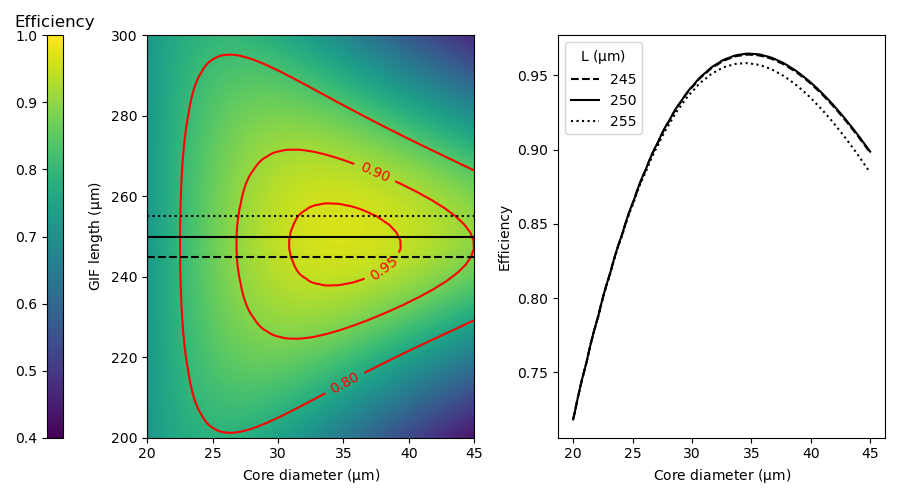

In [21]:
styles = ['dashed', 'solid', 'dotted']

fig, [ax0, ax1, ax2] = plt.subplots(1, 3, num='Heatmap', figsize=(9,5), gridspec_kw={'width_ratios': [0.05, 1,1]})


# Heat map with contours
col = ax1.imshow(etas, cmap='viridis', extent=[20,45,200,300], aspect='auto', vmax=1, vmin=0.4)
clvs = [0.8, 0.9, 0.95]
conts = ax1.contour(etas, levels=clvs ,origin='lower', colors=['red'], extent=[20,45,200,300])
ax1.clabel(conts)
ax1.set_xlabel('Core diameter ($\mathrm{\mu m}$)')
ax1.set_ylabel('GIF length ($\mathrm{\mu m}$)')
#plt.gca().set_aspect('auto')

# Colour bar
fig.colorbar(col,cax=ax0)
#ax0.set_title('$\eta$')
ax0.set_title('Efficiency')
ax0.yaxis.set_ticks_position('left')

# Lines on top of heatmap
ax1.axhline(250, c='k')
ax1.axhline(245, c='k', linestyle='dashed')
ax1.axhline(255, c='k', linestyle='dotted')

# Line plot
for _, data in enumerate(line_plot_data):
    ax2.plot(1e6*ds, data, linestyle=styles[_], color='k', label=str(GIF_lengths[_]))
ax2.set_ylabel('Efficiency')
ax2.set_xlabel('Core diameter ($\mathrm{\mu m}$)')
ax2.legend(title='L ($\mathrm{\mu m}$)')


fig.tight_layout()

As can be seen, ththe best efficiency is found for $L$ at one QPD and core diameter close to 34 um.